<h1><center><b> MBA em Ciência de Dados </b></center></h1>
<h3><center> CeMEAI - ICMC/USP - São Carlos</center></h3>

<br><br>
<h2><center><b> Avaliação Final </b></center></h2>
<h3><center> Aprendizado Dinâmico </center></h3>

<br><br>
<h4>Docente: Prof. Cibele Maria Russo Novelli</h4>
<br><br>

In [1]:
## Pacotes usados para o desenvolvimento da avaliação

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima     
np.random.seed(0)

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error,mean_absolute_error

Using TensorFlow backend.


OBS: Foi observado no base de dados que o dia 20/03/2020 possuia o valor 0 para a quantidade de mortes. Isso, provavelmente mostra um caso onde se tem um erro de digitação, ou algum outro tipo de erro. Pois dado, que o os dias anteriores e seguintes a essa data possuem valores , como por exemplo, no dia 19/03/2020 temos 42 casos de mortes e no dia 21/03/2020 temos 109 casos. De forma a minimizar o erro na construção a avaliação dos modelos que serão construídos, um ajuste foi realizado para essa base de dados. Considerei que houve 1 caso no dia 20/03/2020 e subtrai da quantidade do dia 21/03/2020, cujo número de casos ficou 109. Portanto, o número de casos reais observados na base não foram alterados. 

In [11]:
# COVID - Leitura dos dados

covid = pd.read_csv(r'covid19USA.csv', index_col='date', parse_dates=True)

covid.head()

,confirmed,deaths
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


In [12]:
#Quantidade de linhas e Colunas na Base

print(f'O banco de dados COVID possui {covid.shape[0]} colunas e {covid.shape[1]} colunas')

O banco de dados COVID possui 247 colunas e 2 colunas


In [13]:
covid.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', name='date', length=247, freq=None)

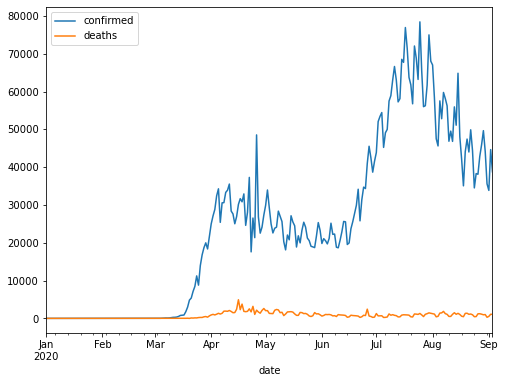

In [14]:
covid.index = covid.index.to_period("D")

covid.plot(figsize=(8,6));

In [15]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 247 entries, 2020-01-01 to 2020-09-03
Freq: D
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   confirmed  247 non-null    int64
 1   deaths     247 non-null    int64
dtypes: int64(2)
memory usage: 5.8 KB


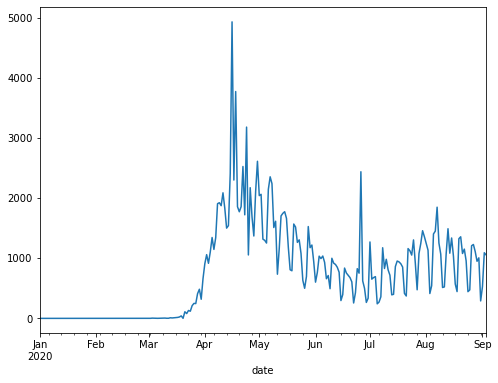

In [16]:
# Série apenas da quantidade de mortes diárias
covid['deaths'].plot(figsize=(8,6));

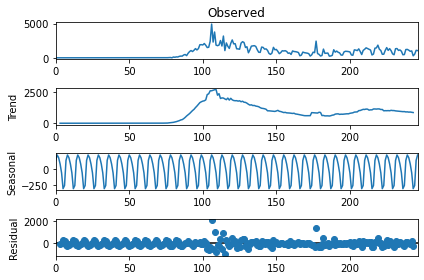

In [17]:
# Observando tendência e sazonalidade da série de morte diária - Modelo aditivo

mortes = np.array(list(covid['deaths']))

result = seasonal_decompose(mortes, model='additive', period=7)
result.plot()

pyplot.show()

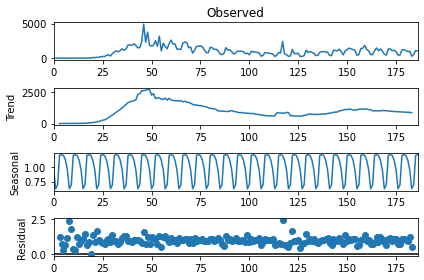

In [204]:
# Observando tendência e sazonalidade da série de morte diária - Modelo multiplicativo

covid2= covid[covid['deaths']>0]

mortes = np.array(list(covid2['deaths']))

result = seasonal_decompose(mortes, model='multiplicative', period=7)
result.plot()

pyplot.show()

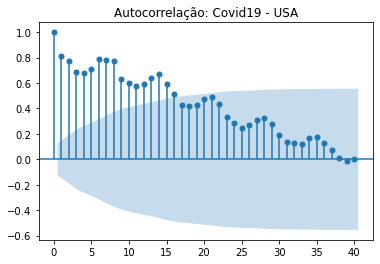

In [111]:
title = 'Autocorrelação: Covid19 - USA'
lags = 40
plot_acf(covid['deaths'],title=title,lags=lags);

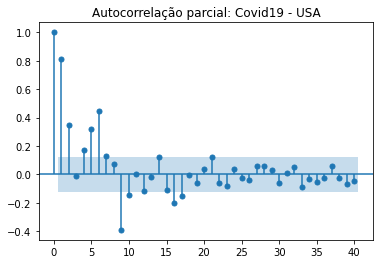

In [112]:
title='Autocorrelação parcial: Covid19 - USA'
lags=40
plot_pacf(covid['deaths'],title=title,lags=lags);

## Divisão da base em treino e teste

In [113]:
#Bases para construção do modelo de holt

dados_treino = covid.iloc[:226] # Dados de treinamento até observação 108, sem incluí-la
dados_teste = covid.iloc[226:] # Dados de teste a partir da observação 108

In [114]:
#Bases para construção do modelo de holt- winters

covid_zero = covid[covid['deaths']>0]
print(len(covid_zero))

dados_treino_zero = covid_zero.iloc[:166] # Dados de treinamento até observação 108, sem incluí-la
dados_teste_zero = covid_zero.iloc[166:] # Dados de teste a partir da observação 108

187


## Modelo Holt

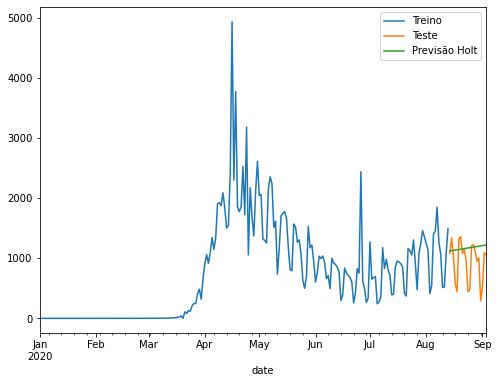

In [115]:
#Tendência aditiva

ajustado_H_add = ExponentialSmoothing(dados_treino['deaths'],trend='add').fit()   
predito_H_add = ajustado_H_add.forecast(21).rename('Previsão Holt')

dados_treino['deaths'].plot(legend=True,label='Treino')
dados_teste['deaths'].plot(legend=True,label='Teste',figsize=(8,6))
predito_H_add.plot(legend=True,label='Previsão Holt');

covid['Holt_add'] = predito_H_add;
#ajustado.fittedvalues.shift(-1);

#covid.head()



In [116]:
covid

,confirmed,deaths,Holt_add
date,,,
2020-01-01,0,0,NaN
2020-01-02,0,0,NaN
2020-01-03,0,0,NaN
2020-01-04,0,0,NaN
2020-01-05,0,0,NaN
...,...,...,...
2020-08-30,44143,1006,1199.767814
2020-08-31,35581,290,1204.732001
2020-09-01,33850,529,1209.696187


## Modelo Holt -Winters

In [117]:
# Modelo Holt-Winters aditivo

ajustado_HW_ADD = ExponentialSmoothing(dados_treino['deaths'],trend='add',seasonal='add',seasonal_periods=7).fit()

# Previsão
predito_HW_ADD = ajustado_HW_ADD.forecast(21).rename('Previsão Holt-Winters')
predito_HW_ADD.index = covid['deaths'].index[226:]
predito_HW_ADD.index

PeriodIndex(['2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
             '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
             '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
             '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
             '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02',
             '2020-09-03'],
            dtype='period[D]', name='date', freq='D')

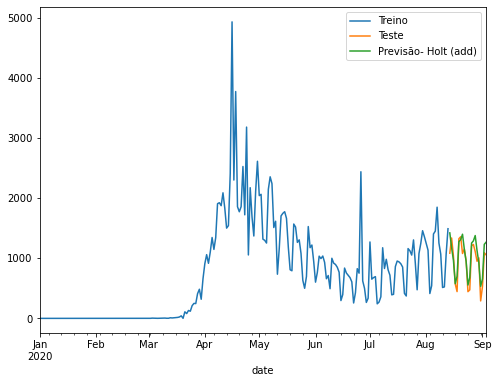

In [118]:
dados_treino['deaths'].plot(legend=True,label='Treino')
dados_teste['deaths'].plot(legend=True,label='Teste',figsize=(8,6))
predito_HW_ADD.plot(legend=True,label='Previsão- Holt (add)');

In [119]:
covid['HW_add'] = predito_HW_ADD
covid

,confirmed,deaths,Holt_add,HW_add
date,,,,
2020-01-01,0,0,NaN,NaN
2020-01-02,0,0,NaN,NaN
2020-01-03,0,0,NaN,NaN
2020-01-04,0,0,NaN,NaN
2020-01-05,0,0,NaN,NaN
...,...,...,...,...
2020-08-30,44143,1006,1199.767814,921.856359
2020-08-31,35581,290,1204.732001,532.076324
2020-09-01,33850,529,1209.696187,656.855425


In [120]:
predito_HW_ADD

date
2020-08-14    1420.667738
2020-08-15    1172.347196
2020-08-16     965.971523
2020-08-17     576.191489
2020-08-18     700.970590
2020-08-19    1274.224864
2020-08-20    1310.485931
2020-08-21    1398.610156
2020-08-22    1150.289614
2020-08-23     943.913941
2020-08-24     554.133906
2020-08-25     678.913008
2020-08-26    1252.167282
2020-08-27    1288.428349
2020-08-28    1376.552574
2020-08-29    1128.232032
2020-08-30     921.856359
2020-08-31     532.076324
2020-09-01     656.855425
2020-09-02    1230.109700
2020-09-03    1266.370766
Freq: D, Name: Previsão Holt-Winters, dtype: float64

In [121]:
# Modelo Holt-Winters Multiplicativo

ajustado_HW_MULT = ExponentialSmoothing(dados_treino_zero['deaths'],trend='mul',seasonal='mul',seasonal_periods=7).fit()

# Previsão
predito_HW_MULT = ajustado_HW_MULT.forecast(21).rename('Previsão Holt-Winters (mult)')
predito_HW_MULT.index = covid['deaths'].index[226:]
predito_HW_MULT.index

PeriodIndex(['2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
             '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
             '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
             '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
             '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02',
             '2020-09-03'],
            dtype='period[D]', name='date', freq='D')

In [122]:
predito_HW_MULT

date
2020-08-14    1248.161735
2020-08-15    1366.949579
2020-08-16    1062.002124
2020-08-17     833.844133
2020-08-18     382.875812
2020-08-19     485.722621
2020-08-20    1083.704490
2020-08-21    1026.444338
2020-08-22    1124.131285
2020-08-23     873.353218
2020-08-24     685.724106
2020-08-25     314.863610
2020-08-26     399.441210
2020-08-27     891.200481
2020-08-28     844.111744
2020-08-29     924.446056
2020-08-30     718.214988
2020-08-31     563.915401
2020-09-01     258.932765
2020-09-02     328.486411
2020-09-03     732.891950
Freq: D, Name: Previsão Holt-Winters (mult), dtype: float64

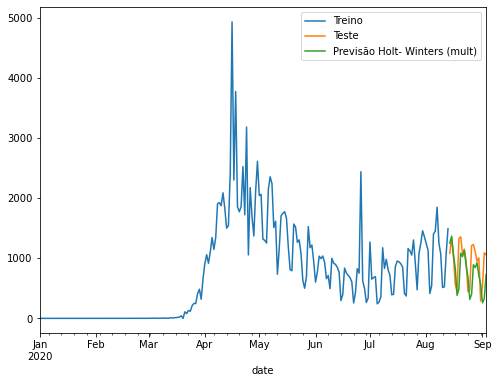

In [123]:
dados_treino['deaths'].plot(legend=True,label='Treino')
dados_teste['deaths'].plot(legend=True,label='Teste',figsize=(8,6))
predito_HW_MULT.plot(legend=True,label='Previsão Holt- Winters (mult)');

In [124]:
covid['HW_mult'] = predito_HW_MULT
covid

,confirmed,deaths,Holt_add,HW_add,HW_mult
date,,,,,
2020-01-01,0,0,NaN,NaN,NaN
2020-01-02,0,0,NaN,NaN,NaN
2020-01-03,0,0,NaN,NaN,NaN
2020-01-04,0,0,NaN,NaN,NaN
2020-01-05,0,0,NaN,NaN,NaN
...,...,...,...,...,...
2020-08-30,44143,1006,1199.767814,921.856359,718.214988
2020-08-31,35581,290,1204.732001,532.076324,563.915401
2020-09-01,33850,529,1209.696187,656.855425,258.932765


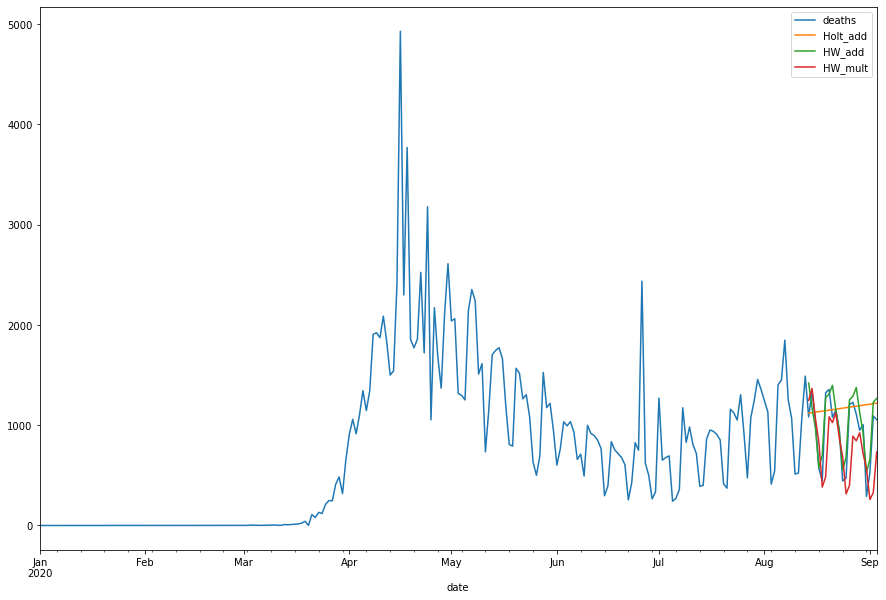

In [125]:
covid[['deaths','Holt_add','HW_add','HW_mult']].plot(figsize=(15,10)).autoscale(axis='x',tight=True);

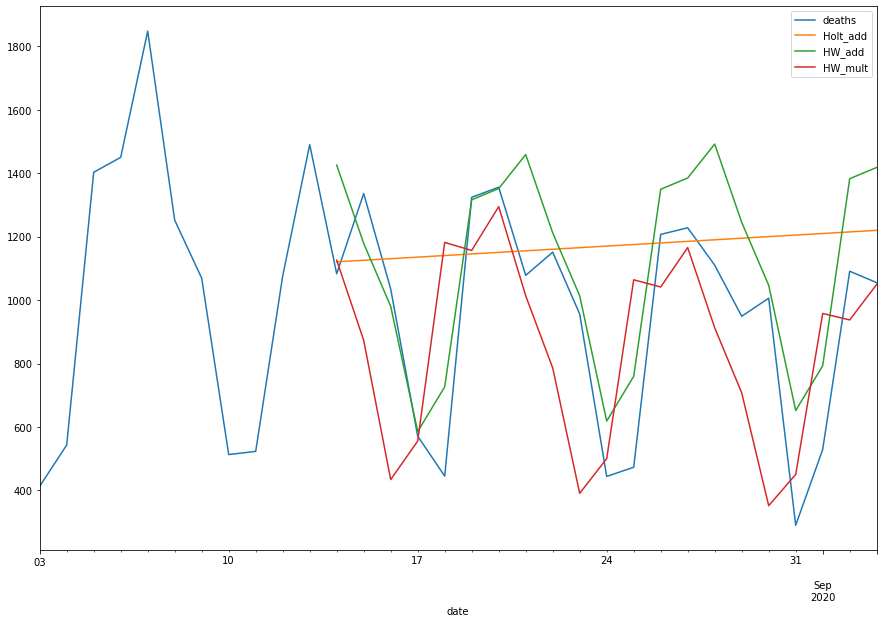

In [29]:
covid[['deaths','Holt_add','HW_add','HW_mult']].iloc[215:].plot(figsize=(15,10)).autoscale(axis='x',tight=True);


## Modelo SARIMA

In [25]:
# Ajuste de modelo SARIMA 

auto_arima(covid['deaths'],seasonal=True,m=7).summary()


stepwise_fit = auto_arima(covid['deaths'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3733.996, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3729.996, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3654.779, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3652.583, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3728.019, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3667.602, Time=0.33 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3596.107, Time=1.36 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3638.859, Time=0.60 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3592.672, Time=2.52 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3603.515, Time=1.16 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3600.251, Time=2.44 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3594.062, Time=2.38 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3688.287, Time=1.27 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3587.460, Time=1.98 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  247
Model:             SARIMAX(3, 1, 3)x(2, 0, [1], 7)   Log Likelihood               -1775.380
Date:                             Wed, 16 Sep 2020   AIC                           3570.759
Time:                                     17:04:01   BIC                           3605.813
Sample:                                          0   HQIC                          3584.874
                                             - 247                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8500      0.060     14.141      0.000       0.732       0.968
ar.L2         -0.4988      0.076     -6.595      0.000      -0.647      -0.351
ar.L3         -0.3830      0.052     -7.340      0.000      -0.485      -0.281
ma.L1         -1.5998      0.067    -23.791      0.000      -1.732      -1.468
ma.L2          1.3640      0.093     14.612      0.000       1.181       1.547
ma.L3         -0.3816      0.062     -6.151      0.000      -0.503      -0.260
ar.S.L7        0.5149      0.348      1.482      0.138      -0.166       1.196
ar.S.L14       0.1639      0.094      1.744      0.081      -0.020       0.348
ma.S.L7       -0.5306      0.339     -1.567      0.117      -1.194       0.133
sigma2      1.094e+05   3972.771     27.529      0.000    1.02e+05    1.17e+05
===================================================================================
Ljung-Box (Q):                       44.36   Jarque-Bera (JB):              7596.73
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):             521.19   Skew:                             2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
modelo = SARIMAX(dados_treino['deaths'],order=(3,1,3),seasonal_order=(2,0,1,7))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              deaths   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(2, 0, [1], 7)   Log Likelihood               -1630.774
Date:                             Wed, 16 Sep 2020   AIC                           3281.548
Time:                                     18:25:52   BIC                           3315.709
Sample:                                 01-01-2020   HQIC                          3295.335
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8059      0.066     12.250      0.000       0.677       0.935
ar.L2         -0.4383      0.085     -5.144      0.000      -0.605      -0.271
ar.L3         -0.4277      0.059     -7.292      0.000      -0.543      -0.313
ma.L1         -1.5543      0.073    -21.306      0.000      -1.697      -1.411
ma.L2          1.2848      0.106     12.125      0.000       1.077       1.493
ma.L3         -0.3403      0.069     -4.917      0.000      -0.476      -0.205
ar.S.L7        0.9320      0.080     11.596      0.000       0.774       1.089
ar.S.L14       0.0665      0.057      1.168      0.243      -0.045       0.178
ma.S.L7       -0.9945      0.084    -11.898      0.000      -1.158      -0.831
sigma2      1.176e+05   2.22e-06   5.29e+10      0.000    1.18e+05    1.18e+05
===================================================================================
Ljung-Box (Q):                       48.31   Jarque-Bera (JB):              7097.79
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):           53754.70   Skew:                             3.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.9e+26. Standard errors may be unstable.
"""

In [127]:
# Obtain predicted values
inicio=len(dados_treino)
fim=len(dados_treino)+len(dados_teste)-1
previsões_SARIMA = resultado.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsões SARIMA(3,1,3)(2,0,1,7)')
previsões_SARIMA.index = dados_teste.index
previsões_SARIMA

date
2020-08-14    1483.766114
2020-08-15    1313.242448
2020-08-16     906.381905
2020-08-17     650.448997
2020-08-18     716.113610
2020-08-19    1083.501325
2020-08-20    1411.296491
2020-08-21    1515.287545
2020-08-22    1306.118010
2020-08-23     952.680964
2020-08-24     676.766351
2020-08-25     726.209120
2020-08-26    1079.328887
2020-08-27    1396.993010
2020-08-28    1497.845692
2020-08-29    1312.938447
2020-08-30     978.380484
2020-08-31     710.631915
2020-09-01     747.511612
2020-09-02    1077.930953
2020-09-03    1380.362971
Freq: D, Name: Previsões SARIMA(3,1,3)(2,0,1,7), dtype: float64

In [128]:
covid['SARIMA'] = previsões_SARIMA
covid

,confirmed,deaths,Holt_add,HW_add,HW_mult,SARIMA
date,,,,,,
2020-01-01,0,0,NaN,NaN,NaN,NaN
2020-01-02,0,0,NaN,NaN,NaN,NaN
2020-01-03,0,0,NaN,NaN,NaN,NaN
2020-01-04,0,0,NaN,NaN,NaN,NaN
2020-01-05,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-08-30,44143,1006,1199.767814,921.856359,718.214988,978.380484
2020-08-31,35581,290,1204.732001,532.076324,563.915401,710.631915
2020-09-01,33850,529,1209.696187,656.855425,258.932765,747.511612


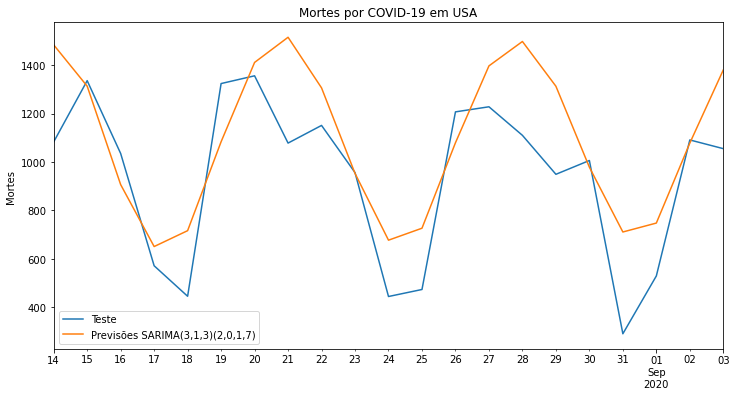

In [130]:
# Plot predictions against known values
title = 'Mortes por COVID-19 em USA'
ylabel='Mortes '
xlabel=''

ax = dados_teste['deaths'].plot(legend=True,figsize=(12,6),title=title, label='Teste')
previsões_SARIMA.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Modelo Redes Dinâmicas

In [141]:
df = covid.drop(['confirmed', 'SARIMA', 'Holt_add','HW_add','HW_mult'], axis=1)
df
#covid.index = covid.index.to_period("D")
#idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
#df = df.reindex(idx)
#df.fillna(0,inplace=True)

,deaths
date,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2020-08-30,1006
2020-08-31,290
2020-09-01,529


In [142]:
#Padronizando os dados

dados_treino = df.iloc[:226] 
dados_teste = df.iloc[226:]

scaler = MinMaxScaler()
scaler.fit(dados_treino)

MinMaxScaler()

In [143]:
scaled_train = scaler.transform(dados_treino)
scaled_test = scaler.transform(dados_teste)

In [144]:
print(scaled_train.min(),scaled_train.max())

0.0 1.0


In [145]:
print(scaled_test.min(),scaled_test.max())

0.0588474025974026 0.27516233766233766


In [174]:
# defina o gerador
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [175]:
# Qual é a aparência do primeiro lote?
X,y = generator[0]
print(f'Dado o array: \n{X.flatten()}');
print(f'Previsão: \n {y}');

Dado o array: 
[0. 0. 0. 0. 0. 0. 0.]
Previsão: 
 [[0.]]


In [177]:
# Defina o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [178]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [179]:
# Ajuste do modelo

model.fit_generator(generator,epochs=100)

Epoch 1/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0133
Epoch 2/100
219/219 [==============================] - 1s 6ms/step - loss: 0.0085
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0080
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0082
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0082
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0084
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 8/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0079
Epoch 9/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 10/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0080
Epoch 11/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0075
Epoch 12/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 13/100


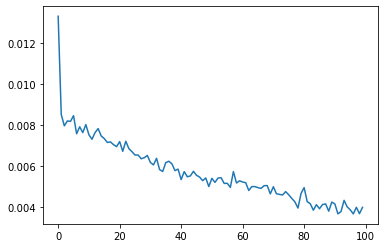

In [180]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [181]:
# Vejamos passo a passo como é feita a previsão, a princípio para a próxima observação usando o tamanho do lote igual a 7

first_eval_batch = scaled_train[-7:]
first_eval_batch

array([[0.375     ],
       [0.25405844],
       [0.2169237 ],
       [0.10409903],
       [0.10612825],
       [0.21834416],
       [0.3023539 ]])

In [182]:
# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(dados_teste)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [183]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[1323.01540756],
       [1322.36112022],
       [1071.4838562 ],
       [ 806.46708298],
       [ 701.12873077],
       [1065.89414215],
       [1425.73205757],
       [1517.6768322 ],
       [1470.78477097],
       [1301.4540329 ],
       [1071.91799164],
       [ 892.43955803],
       [1084.96680164],
       [1488.10965347],
       [1656.83501053],
       [1665.58322144],
       [1518.56610489],
       [1330.03192329],
       [1100.00020981],
       [1157.76027012],
       [1624.9389801 ]])

In [184]:
dados_teste['Predictions'] = true_predictions
dados_teste

,deaths,Predictions
date,,
2020-08-14,1083,1323.015408
2020-08-15,1336,1322.361120
2020-08-16,1035,1071.483856
2020-08-17,571,806.467083
2020-08-18,445,701.128731
2020-08-19,1324,1065.894142
2020-08-20,1356,1425.732058
2020-08-21,1078,1517.676832
2020-08-22,1151,1470.784771


In [185]:
dados_teste['Predictions'].index = covid['deaths'].index[226:]
dados_teste['Predictions'].index

PeriodIndex(['2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
             '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
             '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
             '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
             '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02',
             '2020-09-03'],
            dtype='period[D]', name='date', freq='D')

In [186]:
covid['LSTM'] = dados_teste['Predictions']
covid

,confirmed,deaths,Holt_add,HW_add,HW_mult,SARIMA,LSTM
date,,,,,,,
2020-01-01,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-02,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-03,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-04,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-05,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-08-30,44143,1006,1199.767814,921.856359,718.214988,978.380484,1518.566105
2020-08-31,35581,290,1204.732001,532.076324,563.915401,710.631915,1330.031923
2020-09-01,33850,529,1209.696187,656.855425,258.932765,747.511612,1100.000210


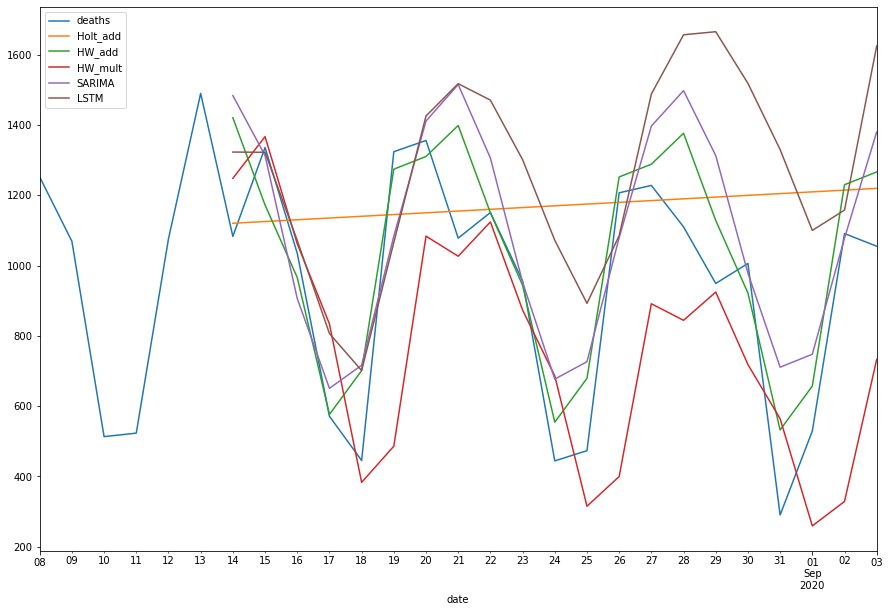

In [187]:
covid[['deaths','Holt_add','HW_add','HW_mult','SARIMA','LSTM']].iloc[220:].plot(figsize=(15,10)).autoscale(axis='x',tight=True);

In [188]:
#Importando o csv com as previsões de cada modelo - somente para a base de teste

csv = covid.to_csv('Base_resultados.csv')

# Avaliação dos Modelos 

In [191]:
#Erro Quadrático Médio

EQM_Holt_add= mean_squared_error(dados_teste['deaths'],covid['Holt_add'].iloc[226:])
EQM_HW_add= mean_squared_error(dados_teste['deaths'],covid['HW_add'].iloc[226:])
EQM_HW_mult= mean_squared_error(dados_teste['deaths'],covid['HW_mult'].iloc[226:])
EQM_SARIMA= mean_squared_error(dados_teste['deaths'],covid['SARIMA'].iloc[226:])
EQM_LSTM= mean_squared_error(dados_teste['deaths'],covid['LSTM'].iloc[226:])

print(EQM_Holt_add);
print(EQM_HW_add);
print(EQM_HW_mult);
print(EQM_SARIMA);
print(EQM_LSTM);


164275.78210099865
29907.33516489706
129774.5254312224
62437.20691213802
196741.31474621306


In [192]:
#Erro absoluto médio

MAE_Holt_add= mean_absolute_error(dados_teste['deaths'],covid['Holt_add'].iloc[226:])
MAE_HW_add= mean_absolute_error(dados_teste['deaths'],covid['HW_add'].iloc[226:])
MAE_HW_mult= mean_absolute_error(dados_teste['deaths'],covid['HW_mult'].iloc[226:])
MAE_SARIMA= mean_absolute_error(dados_teste['deaths'],covid['SARIMA'].iloc[226:])
MAE_LSTM= mean_absolute_error(dados_teste['deaths'],covid['LSTM'].iloc[226:])

print(MAE_Holt_add);
print(MAE_HW_add);
print(MAE_HW_mult);
print(MAE_SARIMA);
print(MAE_LSTM);


294.4704051623216
139.62809105731847
265.27505231417297
206.3734722833678
365.12874430701845


##### O melhor modelo é o modelo Holt-winters Aditivo.

In [195]:
predicao_14_acima = ajustado_HW_ADD.forecast(35).rename('Previsão Holt-Winters')
predicao_14_acima[21:]

2020-09-04    1354.494992
2020-09-05    1106.174450
2020-09-06     899.798776
2020-09-07     510.018742
2020-09-08     634.797843
2020-09-09    1208.052118
2020-09-10    1244.313184
2020-09-11    1332.437410
2020-09-12    1084.116868
2020-09-13     877.741194
2020-09-14     487.961160
2020-09-15     612.740261
2020-09-16    1185.994536
2020-09-17    1222.255602
Freq: D, Name: Previsão Holt-Winters, dtype: float64

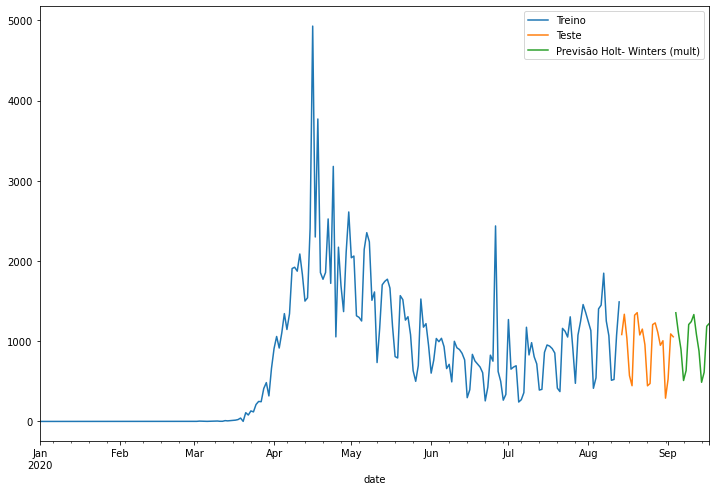

In [198]:
dados_treino['deaths'].plot(legend=True,label='Treino')
dados_teste['deaths'].plot(legend=True,label='Teste',figsize=(12,8))
predicao_14_acima.iloc[21:].plot(legend=True,label='Previsão Holt- Winters (mult)');